### Some extra imports

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.display import clear_output
from assignment.util import binary_accuracy
from assignment import const
import optuna
import random
from assignment.pipeline import init_random_seed
from torch.utils.tensorboard import SummaryWriter

%load_ext autoreload
%autoreload 2

## Assignment 2.3: Text classification via RNN (30 points)

In this assignment you will perform sentiment analysis of the IMDBs reviews by using RNN. An additional goal is to learn high abstactions of the **torchtext** module that consists of data processing utilities and popular datasets for natural language.
 

In [10]:


import torch

from torchtext import datasets

from torchtext.data import Field, LabelField
from torchtext.data import BucketIterator

import torch.nn as nn
import torch.optim as optim

### Preparing Data

In [11]:
TEXT = Field(sequential=True, lower=True)
LABEL = LabelField(dtype=torch.float)

In [12]:
train, tst = datasets.IMDB.splits(TEXT, LABEL)
trn, vld = train.split(random_state=random.seed(const.SEED))

In [13]:
print(vars(trn.examples[0]))

{'text': ['according', 'to', 'john', "ford's", 'lyrically', 'shot,', 'fictional', 'biopic', 'of', 'abraham', "lincoln's", 'life', 'his', 'greatest', 'faults', 'may', 'have', 'been', 'an', 'obtuseness', 'with', 'woman', 'and', 'an', 'ability', 'to', 'dance', 'in', '"the', 'worst', 'way."', "ford's", 'camera', 'has', 'only', 'praising', 'views', 'to', 'reveal', 'of', 'mr.', "lincoln's", 'early', 'life.', 'but', 'for', 'what', 'the', 'film', 'lacks', 'in', 'character', 'complexities', 'it', 'makes', 'up', 'for', 'in', 'beauty', 'and', 'depth', 'of', 'vision.', 'uncharacteristically', 'beautiful', 'compositions', 'of', 'early', 'film,', 'what', 'could', 'have', 'been', 'a', 'series', 'of', 'gorgeous', 'still', 'frames,', 'ford', 'has', 'a', 'unique', 'eye', 'for', 'telling', 'a', 'story.', 'the', 'film', 'sings', 'of', 'the', 'life', 'of', 'a', 'hopeful', 'young', 'man.', 'henry', 'fonda', 'plays', 'the', 'contemplative', 'and', 'spontaneously', 'clever', 'lincoln', 'to', 'a', 'tee,', 'one

In [14]:
%%time
TEXT.build_vocab(trn)

Wall time: 1.43 s


In [15]:
LABEL.build_vocab(trn)

The vocab.freqs is a collections.Counter object, so we can take a look at the most frequent words.

In [16]:
TEXT.vocab.freqs.most_common(10)

[('the', 224964),
 ('a', 111121),
 ('and', 110521),
 ('of', 100961),
 ('to', 93541),
 ('is', 72924),
 ('in', 63004),
 ('i', 49283),
 ('this', 48759),
 ('that', 46362)]

In [17]:
len(TEXT.vocab),


(201009,)

## Let's check is dataset balanced or not

In [18]:
LABEL.vocab.freqs

Counter({'pos': 8807, 'neg': 8693})

- Dataset Balanced. We can use accuracy metric as well

### Creating the Iterator (2 points)

During training, we'll be using a special kind of Iterator, called the **BucketIterator**. When we pass data into a neural network, we want the data to be padded to be the same length so that we can process them in batch:

e.g.
\[ 
\[3, 15, 2, 7\],
\[4, 1\], 
\[5, 5, 6, 8, 1\] 
\] -> \[ 
\[3, 15, 2, 7, **0**\],
\[4, 1, **0**, **0**, **0**\], 
\[5, 5, 6, 8, 1\] 
\] 

If the sequences differ greatly in length, the padding will consume a lot of wasteful memory and time. The BucketIterator groups sequences of similar lengths together for each batch to minimize padding.

Complete the definition of the **BucketIterator** object

In [19]:
train_iter, val_iter, test_iter = BucketIterator.splits(
        (trn, vld, tst),
        batch_sizes=(64, 64, 64),
        sort=True,
        sort_key=lambda x: len(x.text),# write your code here
        sort_within_batch=False,
        device='cuda',
        repeat=False,
)

Let's take a look at what the output of the BucketIterator looks like. Do not be suprised **batch_first=True**

In [20]:
batch = next(train_iter.__iter__()); batch.text

tensor([[   10,     9, 40719,  ..., 43616,     9,  1161],
        [   20,   511,     2,  ...,     7,  1045,    34],
        [    7,   836, 22119,  ...,     3,    17,  4161],
        ...,
        [    1,     1,     1,  ...,   134,   765,  2647],
        [    1,     1,     1,  ...,  5627,   112,    11],
        [    1,     1,     1,  ...,     1,     1,   796]], device='cuda:0')

The batch has all the fields we passed to the Dataset as attributes. The batch data can be accessed through the attribute with the same name.

In [21]:
batch.__dict__.keys()

dict_keys(['batch_size', 'dataset', 'fields', 'input_fields', 'target_fields', 'text', 'label'])

### Define the RNN-based text classification model (10 points)

Start simple first. Implement the model according to the shema below.  
![alt text](https://miro.medium.com/max/1396/1*v-tLYQCsni550A-hznS0mw.jpeg)


In [22]:
from assignment.model import RNNBaseline

In [23]:
em_sz = 200
nh = 300


vocab_size = len(TEXT.vocab)
model = RNNBaseline(hidden_dim=nh, emb_dim=em_sz, vocab_size=vocab_size); model

RNNBaseline(
  (emb): Embedding(201009, 200, padding_idx=1)
  (rnn): GRU(200, 300)
  (out): Linear(in_features=300, out_features=1, bias=True)
)

If you're using a GPU, remember to call model.cuda() to move your model to the GPU.

In [24]:
model.cuda()

RNNBaseline(
  (emb): Embedding(201009, 200, padding_idx=1)
  (rnn): GRU(200, 300)
  (out): Linear(in_features=300, out_features=1, bias=True)
)

### The training loop (3 points)

Define the optimization and the loss functions.

In [25]:
opt = optim.Adam(params=model.parameters(), lr=1e-3)
loss_func = nn.BCEWithLogitsLoss().cuda()

Define the stopping criteria.

In [26]:
epochs = 3

In [27]:
# tb_writer.add_graph(model, batch.text)
# tb_writer.flush()

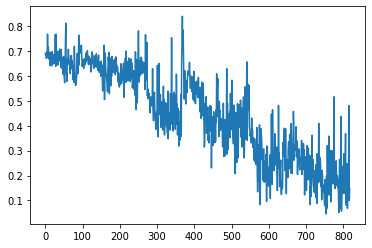

Epoch: 3, Training Loss: 0.2384117673946558, Validation Loss: 0.4334267776901439, Accuracy: 0.8055261373519897
Wall time: 1min 14s


In [28]:
%%time

tb_writer = SummaryWriter('runs/task3/general')
init_random_seed()
history = []
for epoch in range(1, epochs + 1):
    running_loss = 0.0
    running_corrects = 0
    model.train()
    for id_batch, batch in enumerate(train_iter):

        x = batch.text
        y = batch.label

        opt.zero_grad()
        preds, _ = model(x)
        loss = loss_func(preds, y)
        loss.backward()
        opt.step()
        running_loss += loss.item()

        tb_writer.add_scalar('Loss/Train', loss.item(), epoch * len(train_iter) + id_batch)


        # visualizing training process
        history.append(loss.item())
        i = 0
        if (id_batch + 1) % 10 == 0:
            i+=1
            clear_output(True)
            plt.plot(history, label='Loss')
            plt.show()
            # tb_writer.add_scalar('Loss/Train', running_loss / (10 * i), epoch * len(train_iter) + id_batch)
        # print(loss.item())

    epoch_loss = running_loss / len(train_iter)

    val_loss = 0.0
    val_acc = 0.0
    model.eval()
    for batch in val_iter:

        x = batch.text
        y = batch.label

        preds, _ = model(x)
        loss = loss_func(preds, y)
        val_loss += loss.item()

        val_acc += binary_accuracy(preds, y)

    val_loss /= len(val_iter)
    val_acc /= len(val_iter)
    tb_writer.add_scalar('Loss/Valid', val_loss, (1 + epoch) * len(train_iter))
    tb_writer.add_scalar('Accuracy/Valid', val_acc, (1 + epoch) * len(train_iter))
    print('Epoch: {}, Training Loss: {}, Validation Loss: {}, Accuracy: {}'.format(epoch, epoch_loss, val_loss, val_acc))
tb_writer.close()


### Calculate performance of the trained model (5 points)

In [31]:
from assignment.pipeline import model_performance_calculator

model_performance_calculator(model, test_iter)
# Accuracy: 0.8457599878311157, Precision: 0.8822072744369507, Recall: 0.7980800271034241, F1: 0.8380376100540161

Accuracy: 0.8457599878311157, Precision: 0.8822072744369507, Recall: 0.7980800271034241, F1: 0.8380376100540161


Write down the calculated performance

### Accuracy: 0.8457599878311157
### Precision: 0.8822072744369507
### Recall: 0.7980800271034241
### F1: 0.8380376100540161

### Experiments (10 points)

Experiment with the model and achieve better results. You can find advices [here](https://arxiv.org/abs/1801.06146). Implement and describe your experiments in details, mention what was helpful.

### 1. Hyperparameter search for baseline
#### Hidden state and Embeddings dimension adjusted (helpful)
- Accuracy: 0.8466399908065796
- Precision: 0.8304606676101685
- Recall: 0.8711199760437012
- F1: 0.8503045439720154
#### Validation loss with different and selected parameters
<img src="./img/t3_exp1.png">

### 2. Finetuning
#### Froze encoder, train linear layer decoder (helpful, metric depend)
- Accuracy: 0.8488799929618835
- Precision: 0.8508447408676147
- Recall: 0.8460800051689148
- F1: 0.8484557271003723

Accuracy slight improved, F1 slight decrease.
Probably possible to achieve much better results with full "Target task classifier fine-tuning" from 1801.06146.pdf via more advanced classifier implementation
#### Validation loss during "finetuning"
<img src="./img/t3_exp2.svg">

### 3. Bidirectional model (helpful)
####  Different environment used(colab)
#### Baseline (one direction) with tuned parameters then
- Accuracy: 0.841759979724884
- Precision: 0.8598382472991943
- Recall: 0.8166400194168091
- F1: 0.8376825451850891
#### Bidirectional + max pooling for hidden
- Accuracy: 0.8443999886512756
- Precision: 0.8950991034507751
- Recall: 0.780239999294281
- F1: 0.8337323069572449
#### Bidirectional + average pooling for hidden
- Accuracy: 0.8457199931144714
- Precision: 0.8557083010673523
- Recall: 0.8316799998283386
- F1: 0.8435230255126953



# Let's go
- I will start with hyperparameter search for baseline model

In [32]:
from assignment import pipeline as rhl_pipeline
def objective_baseline(trial):
    tb_writer = SummaryWriter(f'runs/task3/optuna/baseline{trial.number}')
    init_random_seed()
    criterion = nn.BCEWithLogitsLoss().cuda()

    hidden_dim = trial.suggest_int('hidden_dim', 100, 300)
    emb_dim = trial.suggest_int('emb_dim', 100, 200)

    model = RNNBaseline(
        hidden_dim=hidden_dim,
        emb_dim = emb_dim,
        vocab_size = len(TEXT.vocab),
    )

    best_val_loss, _ = rhl_pipeline.train_eval_loop(
        debug=False,
        model=model,
        criterion=criterion,
        epoch_n=50,
        early_stopping_patience=3,
        dataset_train=train_iter,
        dataset_val=val_iter,
        dataloader=lambda batches, *args, **kvargs: batches,
        shuffle_train=False,
        writer=tb_writer,
    )

    tb_writer.add_hparams({'hidden_dim': hidden_dim, 'emb_dim': emb_dim}, {'hparam/val_loss': best_val_loss})

    tb_writer.close()
    return best_val_loss

In [33]:
from optuna.samplers import TPESampler

sampler = TPESampler(seed=const.SEED)
study = optuna.create_study(study_name='task3_baseline', storage='sqlite:///./.data/optuna_task3.db', load_if_exists=True)

[I 2020-03-29 18:53:05,712] Using an existing study with name 'task3_baseline' instead of creating a new one.


In [0]:
# del model

In [34]:
# Uncomment next line to run some experiments
# study.optimize(objective_baseline, n_trials=17, n_jobs=1)

In [1]:
optuna.visualization.plot_parallel_coordinate(study)

In [0]:
study.best_params, study.best_value

### Fine tuned baseline

In [0]:
init_random_seed()
criterion = nn.BCEWithLogitsLoss().cuda()

model_fine_tuned_baseline = RNNBaseline(
    hidden_dim=291,
    emb_dim=114,
    vocab_size=len(TEXT.vocab),
)

best_val_loss, model_fine_tuned_baseline = rhl_pipeline.train_eval_loop(
    debug=True,
    model=model_fine_tuned_baseline,
    criterion=criterion,
    epoch_n=50,
    early_stopping_patience=3,
    dataset_train=train_iter,
    dataset_val=val_iter,
    dataloader=lambda batches, *args, **kvargs: batches,
    shuffle_train=False,
)

In [0]:
torch.save(model_fine_tuned_baseline.state_dict(), './model/task3baseline_bft')


In [0]:
model_performance_calculator(model_fine_tuned_baseline, test_iter)

In [0]:
best_val_loss

### Let's froze embs with rnn and start to call last layer training "FineTuning"

In [0]:
print(model_fine_tuned_baseline.parameters())

for param in list(model_fine_tuned_baseline.parameters())[:-1]:
    param.requires_grad = False

params2train = filter(lambda p: p.requires_grad, model_fine_tuned_baseline.parameters())

#Smaller lr then before
optimizer = torch.optim.Adam(params2train, lr=1e-4)

tb_writer = SummaryWriter(f'runs/task3/finetune/baseline')

best_val_loss, model_fine_tuned_baseline = rhl_pipeline.train_eval_loop(
    debug=True,
    model=model_fine_tuned_baseline,
    criterion=criterion,
    epoch_n=50,
    early_stopping_patience=5,
    dataset_train=train_iter,
    dataset_val=val_iter,
    dataloader=lambda batches, *args, **kvargs: batches,
    shuffle_train=False,
    optimizer=optimizer,
    writer=tb_writer
)

tb_writer.close()

In [0]:
torch.save(model_fine_tuned_baseline.state_dict(), './model/task3baseline_ft')

In [0]:
model_performance_calculator(model_fine_tuned_baseline, test_iter)

### Bidirectional Time
#### Done on Google Colab

In [ ]:
from assignment.model import RNNAdvanced

for pooling in ['max', 'average']: # should get same result if bidirectional = False
    for bidirectional in [True, False]:
        init_random_seed()
        criterion = nn.BCEWithLogitsLoss().cuda()
        model_bd = RNNAdvanced(
            hidden_dim=291,
            emb_dim=114,
            vocab_size=len(TEXT.vocab),
            bidirectional=bidirectional,
            pooling = pooling
        )
        
        tb_writer = SummaryWriter(f'runs/task3/bidirectional/{bidirectional}_{pooling}')
        
        best_val_loss, model_bd = rhl_pipeline.train_eval_loop(
            debug=True,
            model=model_bd,
            criterion=criterion,
            epoch_n=50,
            early_stopping_patience=3,
            dataset_train=train_iter,
            dataset_val=val_iter,
            dataloader=lambda batches, *args, **kvargs: batches,
            writer = tb_writer
        )
        
        
        tb_writer.close()
        print(best_val_loss)
        model_performance_calculator(model_bd, test_iter)